In [1]:
import cloudknot as ck

In [2]:
ck.set_region('us-east-1')

In [3]:
def afq_prek_api(subject):
    import logging
    import s3fs
    import numpy as np
    import os.path as op
    import os

    import AFQ.api as api
    
    logging.basicConfig(level=logging.INFO)
    log = logging.getLogger(__name__)  

    #fs = s3fs.S3FileSystem()
    
    sub_prefix = f"sub-"
        
    #dwi_dir = f'prek-diffusion/derivatives/sub-{subject}/dtiInit_ses-pre'
    #dmri_prep_dir = op.join(op.expanduser('~'), 'AFQ_data', 'prek-diffusion/dmri_prep')

    #prek_fdata_src = op.join(dwi_dir, f"sub-{subject}_ses-pre_acq-b1500_dwi_aligned_trilin.nii.gz")
    #prek_fbval_src = op.join(dwi_dir, f"sub-{subject}_ses-pre_acq-b1500_dwi_aligned_trilin.bvals")
    #prek_fbvec_src = op.join(dwi_dir, f"sub-{subject}_ses-pre_acq-b1500_dwi_aligned_trilin.bvecs")
    
    #prek_fdata = f"{dmri_prep_dir}/sub-{subject}/dtiInit_ses-pre/dwi/dwi_aligned_trilin.nii.gz"
    #prek_fbval = f"{dmri_prep_dir}/sub-{subject}/dtiInit_ses-pre/dwi/dwi_aligned_trilin.bvals"
    #prek_fbvec = f"{dmri_prep_dir}/sub-{subject}/dtiInit_ses-pre/dwi/dwi_aligned_trilin.bvecs"
    
    #fs.get(prek_fdata_src, prek_fdata)
    #fs.get(prek_fbval_src, prek_fbval)
    #fs.get(prek_fbvec_src, prek_fbvec)

    #anat_dir = f'prek-diffusion/derivatives/sub-{subject}/freesurfer/mri'
    #fs.get(op.join(anat_dir, f"aparc+aseg.nii.gz"), f"{dmri_prep_dir}/sub-{subject}/dtiInit_ses-pre/anat/aparc+aseg.nii.gz")

    wm_labels=[250, 251, 252, 253, 254, 255, 41, 2, 16, 77]
    b0_threshold = 50

    tracking_params = {"n_seeds": 2, "directions": 'det', "stop_threshold": 0.2}
    segmentation_params = {"prob_threshold": 10, "b0_threshold": b0_threshold}
    clean_params = {"clean_rounds": 1}

    myafq = api.AFQ(f'prek-diffusion/derivatives/sub-{subject}', # dmri_prep_dir,
                    dwi_folder="dtiInit_ses-pre", # "dwi",
                    dwi_file="*ses-pre_acq-b1500_dwi_aligned_trilin", # "dwi*", 
                    anat_folder="freesurfer/mri", #"anat",
                    seg_file="aparc+aseg",
                    wm_labels=wm_labels,
                    use_prealign=False,
                    sub_prefix=sub_prefix,
                    b0_threshold=b0_threshold,

                    tracking_params=tracking_params,
                    segmentation_params=segmentation_params,
                    clean_params=clean_params)

    #myafq.export_rois()
    #myafq.export_registered_b0()
    myafq.export_bundles()
    myafq.combine_profiles()
    #bucket_name = f'prek-diffusion/derivatives/{sub_prefix}/pyafq'

In [4]:
#afq_prek_api(1110)

In [5]:
afq_knot = ck.Knot(name='afq_prek-64gb-19326-0',
                  func=afq_prek_api,
                  base_image='python:3.7',
                  image_github_installs="https://github.com/36000/pyAFQ.git@api-fixes-2",
                  pars_policies=('AmazonS3FullAccess',),
                  resource_type="SPOT",
                  bid_percentage=100,
                  memory=64000)

IndexError: list index out of range

In [ ]:
inputs = [1110,
          1112,
          1113]

In [ ]:
ft = afq_knot.map(inputs)

In [ ]:
afq_knot.view_jobs()

In [10]:
j0 = afq_knot.jobs[0]

In [13]:
j0.status

{'status': 'PENDING',
 'statusReason': None,
 'attempts': [],
 'arrayProperties': {'statusSummary': {'STARTING': 1,
   'FAILED': 0,
   'RUNNING': 18,
   'SUCCEEDED': 0,
   'RUNNABLE': 2,
   'SUBMITTED': 0,
   'PENDING': 0},
  'size': 21}}

In [12]:
afq_knot.clobber()

In [92]:
import s3fs
s3 = s3fs.S3FileSystem(anon=False)

try:
    s3.get(f'prek-diffusion/derivatives/AFQ_allvols_rt_ses-pre_19-Nov-2019.mat', 'source.mat')
except FileNotFoundError:
    print(f'mAFQ streamlines not found')
    
# use AFQ browser to process this

In [89]:
for subject in inputs:
    try:
        s3.get(f'prek-diffusion/derivatives/sub-{subject}/pyafq/sub-{subject}/sub-{subject}_model-csd_track-det_segment-afq_profiles.csv', f'sub-{subject}_pyAFQ_profiles.csv')
    except FileNotFoundError:
        print(f'subject {subject} streamlines not found')

In [40]:
import pandas as pd
import numpy as np
profiles_matlab = pd.read_csv('./AFQ-browser/client/data/nodes.csv')

In [ ]:
print(profiles_matlab['tractID'].unique())
print(profiles_afq['Bundle'].unique())

In [41]:
def tract_map(name):
    if name == 'Right Corticospinal':
        return 'CST_R'
    elif name == 'Left Corticospinal':
        return 'CST_L'
    elif name == 'Right Uncinate':
        return 'UNC_R'
    elif name == 'Left Uncinate':
        return 'UNC_L'
    elif name == 'Left IFOF':
        return 'IFO_L'
    elif name == 'Right IFOF':
        return 'IFO_R'
    elif name == 'Right Arcuate':
        return 'ARC_R'
    elif name == 'Left Arcuate':
        return 'ARC_L'
    else:
        return name
        
#profiles_matlab['tractID'].unique()
profiles_matlab['subjectID'] = profiles_matlab['subjectID'].apply(lambda x: pd.to_numeric(x[-4:]))
profiles_matlab['tractID'] = profiles_matlab['tractID'].apply(tract_map)

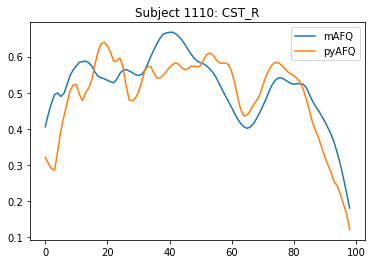

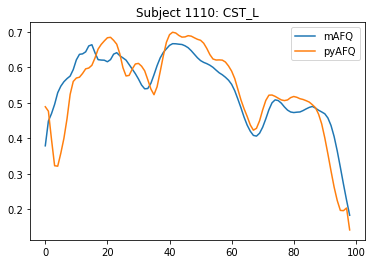

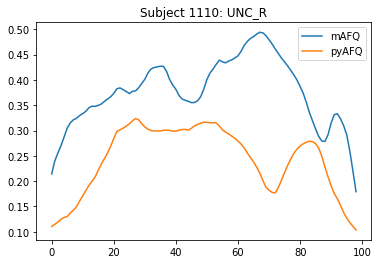

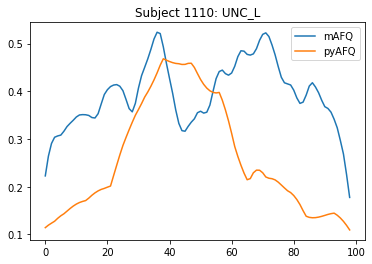

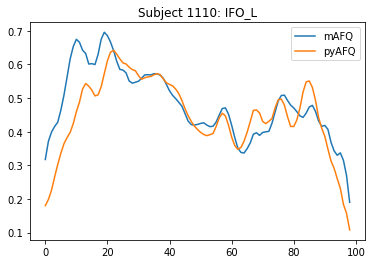

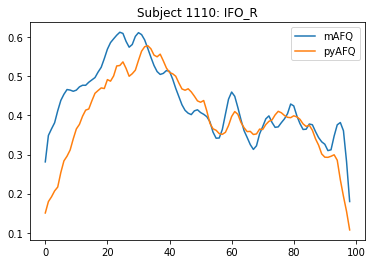

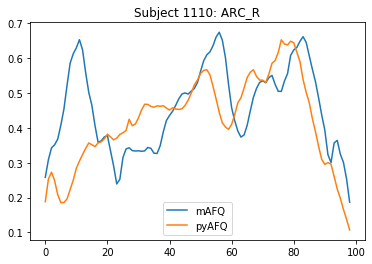

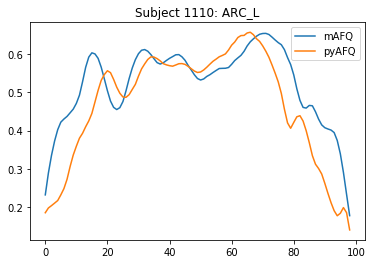

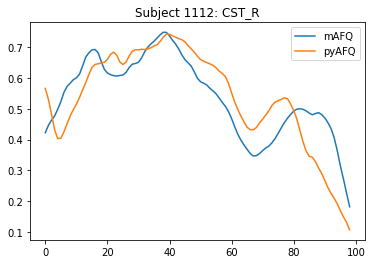

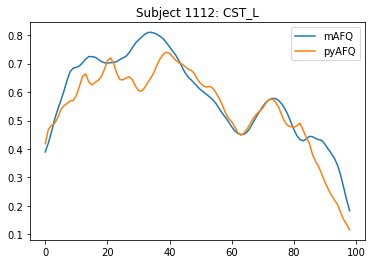

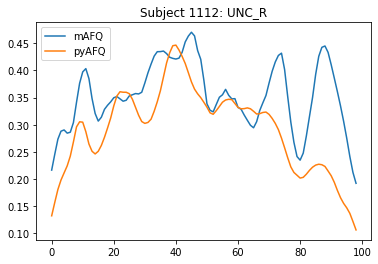

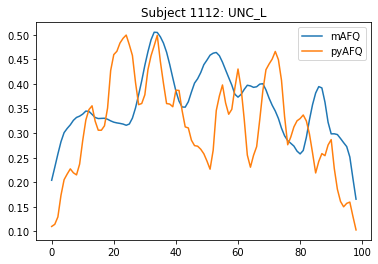

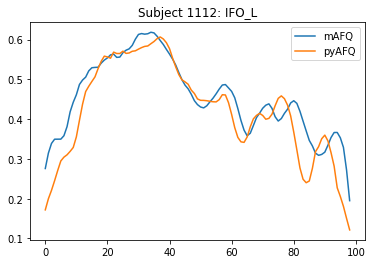

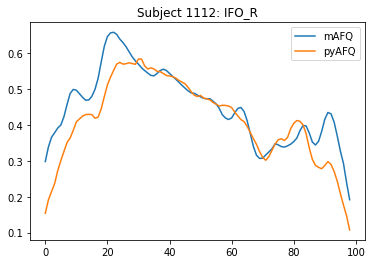

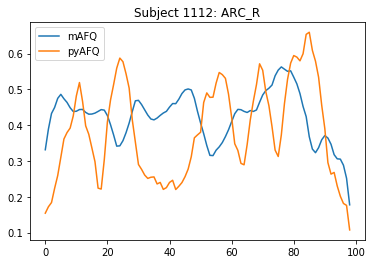

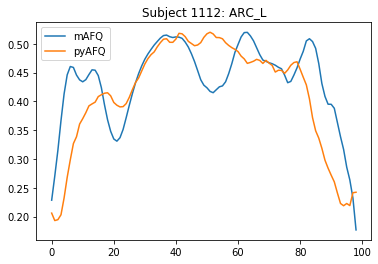

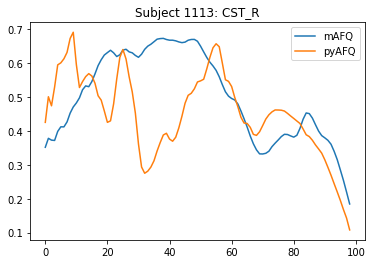

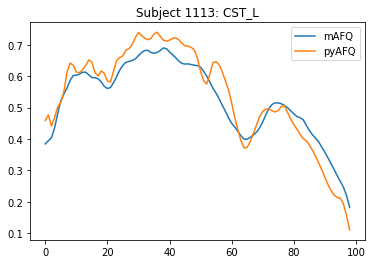

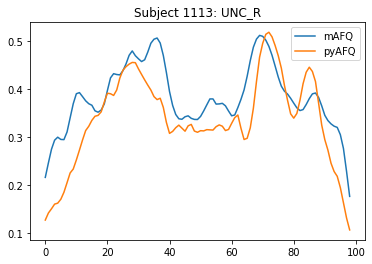

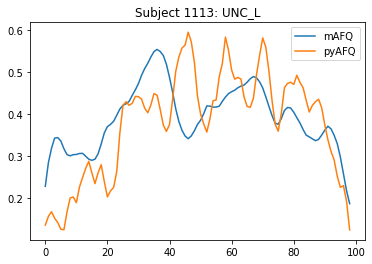

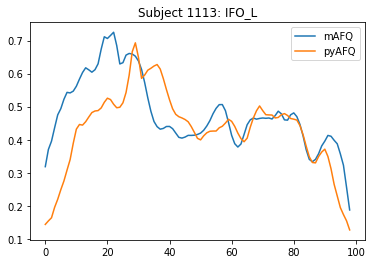

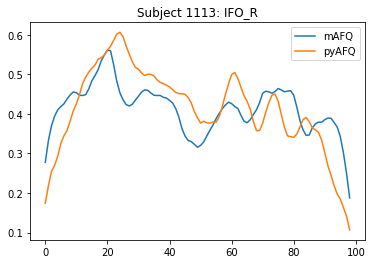

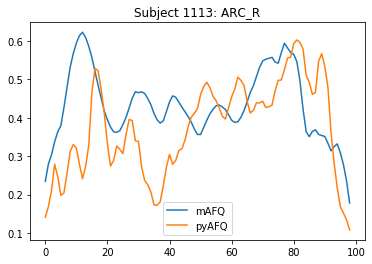

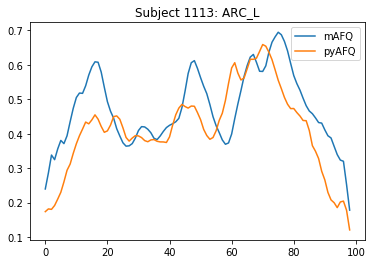

Mean Percent Differences
            1110        1112        1113
CST_R -0.0430925 -0.00521673  -0.0593833
CST_L -0.0135399  -0.0743828   0.0092061
UNC_R   -0.35056   -0.179563   -0.134404
UNC_L  -0.333765  -0.0973348  -0.0419873
IFO_L -0.0643257  -0.0823406  -0.0904669
IFO_R  -0.082554  -0.0891679 -0.00666574
ARC_R -0.0527951  -0.0689092   -0.122151
ARC_L  -0.119837  -0.0484928   -0.124337


In [48]:
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score
bundles = ['CST_R', 'CST_L', 'UNC_R', 'UNC_L', 'IFO_L', 'IFO_R', 'ARC_R', 'ARC_L']
subjects = [1110,1112,1113]

percent_diffs = pd.DataFrame(index=bundles, columns=subjects)
for subject in subjects:
    for bundle in bundles:
        profiles_afq = pd.read_csv(f'sub-{subject}_pyAFQ_profiles.csv')

        ml_test = profiles_matlab[(profiles_matlab['subjectID'] == subject) & (profiles_matlab['tractID'] == bundle)]['fa']
        afq_test = profiles_afq[(profiles_afq['Subject'] == subject) & (profiles_afq['Bundle'] == bundle)]['Value']
        ml_test = ml_test.to_numpy()[1:]
        afq_test = afq_test.to_numpy()[1:]
        plt.plot(ml_test)
        plt.plot(afq_test)
        plt.title('Subject ' + str(subject) + ': ' + bundle)
        plt.legend(['mAFQ', 'pyAFQ'])
        plt.show()
        
        
        percent_diffs.at[bundle, subject] = np.mean((afq_test - ml_test)/ml_test)

print('Mean Percent Differences')
print(percent_diffs)